# Importing and Exploratory Data Analysis

In [1]:
import pandas as pd

Read the data from a .csv file, and view the first few rows.

In [2]:
hotdog = pd.read_csv('Q2_citi_vendors.csv')
hotdog.head()

,game,day,section,vendor,hot_dogs_sold
0,1,2,1,6,145
1,1,2,2,10,121
2,1,2,3,21,56
3,1,2,4,8,123
4,1,2,5,4,100


And view the useful `df.info()`

In [3]:
hotdog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   game           1620 non-null   int64
 1   day            1620 non-null   int64
 2   section        1620 non-null   int64
 3   vendor         1620 non-null   int64
 4   hot_dogs_sold  1620 non-null   int64
dtypes: int64(5)
memory usage: 63.4 KB


All data is numerical and represents ID values for each feature. Get the feature domains for each of the 4 independent variables.

In [4]:
def feature_domains(df,col):
    grouped = df.groupby(col).count()
    count = grouped.index.to_numpy()[-1]
    print(f"The independent variable '{col}' takes on {count} possible values for this problem.")

In [5]:
indep_cols = hotdog.columns[0:4]
for col in indep_cols:
    feature_domains(hotdog,col)

The independent variable 'game' takes on 81 possible values for this problem.
The independent variable 'day' takes on 7 possible values for this problem.
The independent variable 'section' takes on 20 possible values for this problem.
The independent variable 'vendor' takes on 30 possible values for this problem.


So it is clear that all home games in a season are sampled for 30 different vendors in 1 of 20 possible sections. This information is invaluable.

And for each of the 30 vendors, it is imperative to find the amount of game/section/days samples taken.

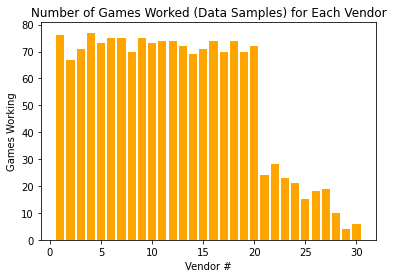

In [6]:
import matplotlib.pyplot as plt

x = hotdog['vendor'].value_counts().sort_index(ascending = True)

plt.figure()
plt.bar(x = x.index,height= x.values,color = 'orange')
plt.xlabel('Vendor #')
plt.ylabel('Games Working')
plt.title('Number of Games Worked (Data Samples) for Each Vendor')
plt.show()

It seems that most vendors numbered 1 - 20 are more full time employees who work more than 80% of home games each. Then, vendors 21 - 30 are likely part time employees with significantly less samples.

However, by choosing this process, the modelling will provide an understanding of how each feature influences the amount of hot dogs sold. This supercedes the assumption of the 'best' vendor as "the one who sells the highest quantity of hot dogs". We wouldn't disqualify vendor 20 who had worked 4 games if his overall 'selling skill' is higher.

The dependent variable that is to be predicted is the last column, the `hot_dogs_sold`. On the other hand, these other columns seem to represent identifiers for different game, days of the week, section and vendor. As in the pitching example, these categorical, numeric features are not useful for modelling as they merely signify something else. Namely, it is necessary to usurp these identifiers with an aggregation value of the subjects they represent. In this case, the choice of the average amount of `hot_dogs_sold` suffices.

In [7]:
def add_avg_row(df,col):
    """
    
    """
    avg_col = df.groupby(col).mean()['hot_dogs_sold']
    df[f'{col}_avg'] = hotdog[col].apply(lambda x:avg_col[x])
    return df

In [8]:
for col in indep_cols:
    hotdog = add_avg_row(hotdog,col)

In [9]:
# rename avg columns to something more intuitive
hotdog.rename(inplace = True, columns = {'game_avg':'game_hunger_rating',\
                                         'day_avg':'day_hunger_rating',\
                                         'section_avg':'section_hunger_rating',\
                                         'vendor_avg':'vendor_selling_skill'})

With this step complete it is time to progress to the feature selection stage.

# Feature Selection and Modelling

In [10]:
# view current status of dataframe
hotdog.head()

,game,day,section,vendor,hot_dogs_sold,game_hunger_rating,day_hunger_rating,section_hunger_rating,vendor_selling_skill
0,1,2,1,6,145,134.7,125.379167,151.740741,156.906667
1,1,2,2,10,121,134.7,125.379167,127.222222,131.506849
2,1,2,3,21,56,134.7,125.379167,127.037037,159.750000
3,1,2,4,8,123,134.7,125.379167,120.148148,121.728571
4,1,2,5,4,100,134.7,125.379167,130.185185,108.779221


In [11]:
X = hotdog.iloc[:,-5:].copy() # copy to preserve original df with ids. Need all rows, only last 4 columns
X.head()

,hot_dogs_sold,game_hunger_rating,day_hunger_rating,section_hunger_rating,vendor_selling_skill
0,145,134.7,125.379167,151.740741,156.906667
1,121,134.7,125.379167,127.222222,131.506849
2,56,134.7,125.379167,127.037037,159.750000
3,123,134.7,125.379167,120.148148,121.728571
4,100,134.7,125.379167,130.185185,108.779221


Of course, select `hot_dogs_sold` as the dependent vector $y$, and drop it. We are left with the feature vector $X = {x_1,x_2,...x_n}$

In [12]:
y = hotdog['hot_dogs_sold']
X.drop('hot_dogs_sold',axis=1,inplace = True)

In [13]:
y.head()

0    145
1    121
2     56
3    123
4    100
Name: hot_dogs_sold, dtype: int64

Now, it is time to move forward with the modelling stage. For this problem including minimal, numerical values, linear regression fits best. This type of model describes the linear relationship between two or more continuous variables which allows dependent variable prediction for new independent variables. With independent variables $x_p \in X_{ij}$, the linear regression model follows the formula:  $$y_i = \beta_{0} + \beta_{1} x_{i1} + \cdots + \beta_{p} x_{ip} + \varepsilon_i
 \qquad i = 1, \ldots,n $$

It follows, the formula for a linear regression model with three features, as in this case, is the linear combination:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \epsilon ,$$

With the betas representing the increase/decrese of one unit increase that the corresponding independent variable has on the dependent, with the epsilon represents the random error or the variation that the model could not account for. In this case, $\beta_1$ is the batter skill, and $\beta_2$ pitcher skill.

Ordinary Least Squares is the specific method utilized which "minimiz[es] the sum of the squares of the differences between the observed dependent variable (values of the variable being observed) in the input dataset and the output of the (linear) function of the independent variable." [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares)

The `sklearn Linear Regression` model will be instatiated and fit on the data, followed by the `statsmodels` based model. Interestingly, these may vary slightly due to variance from rounding. 

In [14]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X,y)
lin.coef_,lin.intercept_

(array([ 9.89101131e-01, -6.17512967e-04,  9.66479770e-01,  9.66764915e-01]),
 -254.43326842859733)

In [15]:
import statsmodels.api as sm

X_withconstant = sm.add_constant(X) # add constant manually for sm

reg = sm.OLS(y, X_withconstant) # y first for sm

reg_results = reg.fit()

/Users/Daniel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [16]:
print(f'The sk-learn model found an intercept of {lin.intercept_} with betas {lin.coef_}, while the statsmodels version found an intercept of {reg_results.params[0]} and betas of {reg_results.params[1:].values}')

The sk-learn model found an intercept of -254.43326842859733 with betas [ 9.89101131e-01 -6.17512967e-04  9.66479770e-01  9.66764915e-01], while the statsmodels version found an intercept of -254.4332684285987 and betas of [ 9.89101131e-01 -6.17512967e-04  9.66479770e-01  9.66764915e-01]


These results happen to be identical. But when viewing the summary of the `sm` implementation, there is something of note.

In [17]:
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          hot_dogs_sold   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     84.76
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           2.08e-65
Time:                        17:28:22   Log-Likelihood:                -8974.3
No. Observations:                1620   AIC:                         1.796e+04
Df Residuals:                    1615   BIC:                         1.799e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -254.4333     24.606    -10.340      0.000    -302.696    -206.171
game_hunger_rating        0.9891      0.125      7.886      0.000       0.743       1.235
day_hunger_rating        -0.0006      0.158     -0.004      0.997      -0.310       0.309
section_hunger_rating     0.9665      0.132      7.317      0.000       0.707       1.226
vendor_selling_skill      0.9668      0.092     10.477      0.000       0.786       1.148
==============================================================================
Omnibus:                        5.552   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.540
Skew:                           0.143   Prob(JB):                       0.0627
Kurtosis:                       3.006   Cond. No.                     4.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Namely, the `day_hunger_rating` has nearly no effect on the amount of hot dogs sold. Moreover, its p-value is extremely high, which signifies insignificance of the correlation between these. This poses even more of an issue as multicolinearity can exist.

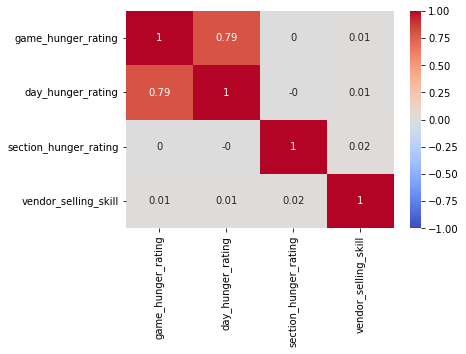

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr()
plt.figure()
sns.heatmap(corr.round(2), vmax = 1, vmin = -1, center = 0, annot =True, cmap = 'coolwarm')
plt.show()

This proves to be true, as day has a strong direct correlation with overall game hunger (i.e. if an overall game is more 'hungry' that drives that day's hunger up too).  Thus, `day` (day of the week) is dropped. 

In [19]:
X.drop('day_hunger_rating',axis = 1,inplace = True)

In [20]:
import statsmodels.api as sm

X_withconstant = sm.add_constant(X) # add constant manually for sm

reg = sm.OLS(y, X_withconstant) # y first for sm

reg_results = reg.fit()

reg_results.summary()

/Users/Daniel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          hot_dogs_sold   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     113.1
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.80e-66
Time:                        17:28:22   Log-Likelihood:                -8974.3
No. Observations:                1620   AIC:                         1.796e+04
Df Residuals:                    1616   BIC:                         1.798e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -254.4635     23.352    -10.897      0.000    -300.268    -208.659
game_hunger_rating        0.9887      0.076     12.966      0.000       0.839       1.138
section_hunger_rating     0.9665      0.132      7.320      0.000       0.707       1.225
vendor_selling_skill      0.9668      0.092     10.481      0.000       0.786       1.148
==============================================================================
Omnibus:                        5.549   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.537
Skew:                           0.143   Prob(JB):                       0.0628
Kurtosis:                       3.006   Cond. No.                     3.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# rerun lin
lin = LinearRegression()
lin.fit(X,y)

LinearRegression()

# Simulation

This situation can be modelled using a simple Monte Carlo simulation. This accounts for variability in probability distributions by generating outcomes based on repeated random samples. In other words, an experiment can be completed thousands of times, each with differing, realistic outcomes. 

The procedure will be as follows:
- for each vendor (1 - 30)
    - generate 5,000 samples by:
        - selecting a random section
        - selecting a random game number
            - and inputing into the model to project the amount of hot dogs sold. 
            - keep running sum
                - divide by 5,000 to find overall average

In [23]:
import random
import numpy as np
from tqdm import tqdm

random.seed(12) # set randomness for code reproduction. Lindor's jersey #

preds = pd.DataFrame(columns=['vendor','game','section','hot_dogs_sold'])
pbar = tqdm(range(1,31)) # tqdm progress bar

for i in pbar: # for one vendor...
    vendor_skill = hotdog.loc[hotdog['vendor'] == i,'vendor_selling_skill'].iloc[0]
    for j in range(1,5000): # one simulation
        rand_section = random.randint(1,20) 
        rand_game = random.randint(1,81)
        
        pbar.set_description(f'Simming for Vendor {i}, Sim Number {j}')
        
        section_hunger = hotdog.loc[hotdog['section'] == rand_section,'section_hunger_rating'].iloc[0]
        game_hunger = hotdog.loc[hotdog['game'] == rand_game,'game_hunger_rating'].iloc[0]
        
        to_pred = pd.DataFrame([game_hunger,section_hunger,vendor_skill]).T
        pred = lin.predict(to_pred).astype(float)
        
        dic = pd.DataFrame(data = [{"vendor":i,'game':rand_game,"section":rand_section,"hot_dogs_sold":pred}])
        preds = pd.concat([preds,dic],ignore_index= True)

Simming for Vendor 30, Sim Number 4999: 100%|███| 30/30 [15:15<00:00, 30.52s/it]


In [30]:
# and find rankings , as type int which rounds down. 
rankings = preds.groupby('vendor').mean()['hot_dogs_sold'].sort_values(ascending = False).astype(int) 
rankings

vendor
29    205
20    169
21    158
6     155
24    154
3     151
27    146
16    144
5     141
2     139
15    139
14    135
28    134
9     131
10    131
11    129
30    129
17    128
22    127
19    126
7     122
8     122
25    121
23    120
18    120
13    116
1     115
4     109
12    107
26    105
Name: hot_dogs_sold, dtype: int64

Interestingly, vendor 29 who worked the least number of games has the highest average prediction. There is possibilities of a skewed 'skill' given the dearth of instances, but that is beyond the scope of the data. As it stands, vendor 29 is the highest ranked.

In [35]:
# sample # 371 from original data is impressive
hotdog.loc[hotdog['vendor']== 29]

,game,day,section,vendor,hot_dogs_sold,game_hunger_rating,day_hunger_rating,section_hunger_rating,vendor_selling_skill
238,12,6,19,29,200,129.05,150.300000,134.098765,208.5
371,19,6,12,29,332,173.70,150.300000,131.790123,208.5
572,29,2,13,29,67,160.85,125.379167,134.975309,208.5
1446,73,4,7,29,235,132.70,127.150000,105.777778,208.5
